# Predicting Customers' Financial Decision

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import random
import os
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,classification_report,precision_score,auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


#### Data processing and EDA

In [2]:
data = pd.read_csv(r'Churn Modeling.csv')

In [3]:
data = data.dropna()

In [4]:
print(data.shape)
print(list(data.columns))

(10000, 14)
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [5]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

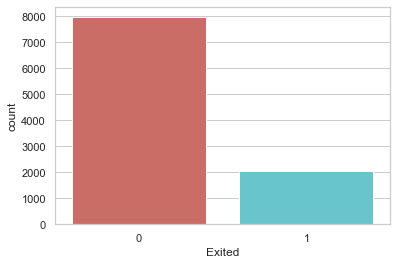

In [7]:
sns.countplot(x='Exited', data = data, palette = 'hls')
plt.show()

In [8]:
count_Stay = len(data[data['Exited']==0])
count_Left = len(data[data['Exited']==1])
pct_of_Stay = count_Stay/(count_Stay+count_Left)
print("percentage of customers that stayed is ", pct_of_Stay*100)
pct_of_Left = count_Left/(count_Stay+count_Left)
print(f"percentage of customers that left is {pct_of_Left*100:.2f}")

percentage of customers that stayed is  79.63
percentage of customers that left is 20.37


In [9]:
data.groupby('Exited').mean()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,,
0,5024.694964,1.569117e+07,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,4905.917526,1.569005e+07,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


We observed that for people who exited, the age is younger, balance is lower and they are more likely to be active members.

Text(0, 0.5, 'Proportion of Customers')

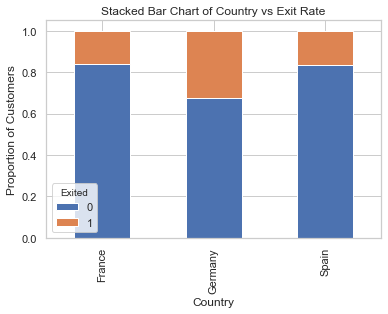

In [10]:
table=pd.crosstab(data.Geography,data.Exited)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Country vs Exit Rate')
plt.xlabel('Country')
plt.ylabel('Proportion of Customers')


# Logistic Regression

In [11]:
cat_vars=['Geography','Gender','HasCrCard','IsActiveMember']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['Geography','Gender','HasCrCard','IsActiveMember']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1',
       'IsActiveMember_0', 'IsActiveMember_1'], dtype=object)

In [12]:
data_final = data_final.drop(labels = ['RowNumber','CustomerId','Surname'], axis = 1)

With our training data created, I’ll up-sample the non-Exited using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE works by creating synthetic samples from the minor class (non-Exited) instead of creating copies. It randomly choose one of the k-nearest-neighbors and use it to create a similar, but randomly tweaked, new observations.

In [13]:

X = data_final.loc[:, data_final.columns != 'Exited']
y = data_final.loc[:, data_final.columns == 'Exited']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Exited'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Exited']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Exited']==1]))
print("Proportion of no Exit data in oversampled data is ",len(os_data_y[os_data_y['Exited']==0])/len(os_data_X))
print("Proportion of Exited data in oversampled data is ",len(os_data_y[os_data_y['Exited']==1])/len(os_data_X))

length of oversampled data is  11168
Number of no subscription in oversampled data 5584
Number of subscription 5584
Proportion of no Exit data in oversampled data is  0.5
Proportion of Exited data in oversampled data is  0.5


In [14]:
data_final_vars=data_final.columns.values.tolist()
y=['Exited']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [15]:
cols=['CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1',
       'IsActiveMember_0', 'IsActiveMember_1'] 
X=os_data_X[cols]
y=os_data_y['Exited']

In [16]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.351507
         Iterations 8
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.493    
Dependent Variable:   Exited           AIC:              7881.2505
Date:                 2020-05-03 16:32 BIC:              7991.0627
No. Observations:     11168            Log-Likelihood:   -3925.6  
Df Model:             14               LL-Null:          -7741.1  
Df Residuals:         11153            LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       8.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
CreditScore        0.0042   0.0002  16.9729 0.0000  0.0037  0.0047
Age                0.1058   0.0028  37.9638 0.0000  0

In [17]:
cols=['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1',
       'IsActiveMember_0', 'IsActiveMember_1'] 
X=os_data_X[cols]
y=os_data_y['Exited']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.351510
         Iterations 8
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.493    
Dependent Variable:   Exited           AIC:              7879.3363
Date:                 2020-05-03 16:32 BIC:              7981.8276
No. Observations:     11168            Log-Likelihood:   -3925.7  
Df Model:             13               LL-Null:          -7741.1  
Df Residuals:         11154            LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       8.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
CreditScore        0.0042   0.0002  16.9966 0.0000  0.0037  0.0047
Age                0.1058   0.0028  37.9836 0.0000  0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [20]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1364  291]
 [ 336 1360]]


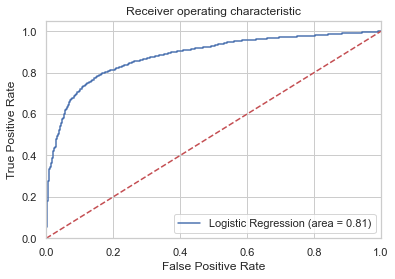

In [21]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## KNN model

In [22]:
data=data.drop(columns=['RowNumber','CustomerId','Surname'])

#### Data processing and EDA

In [23]:
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
Gender_Female        0
Gender_Male          0
HasCrCard_0          0
HasCrCard_1          0
IsActiveMember_0     0
IsActiveMember_1     0
dtype: int64

In [24]:
data.duplicated().sum()

0

In [25]:
num_cols = data.select_dtypes(include = np.number)

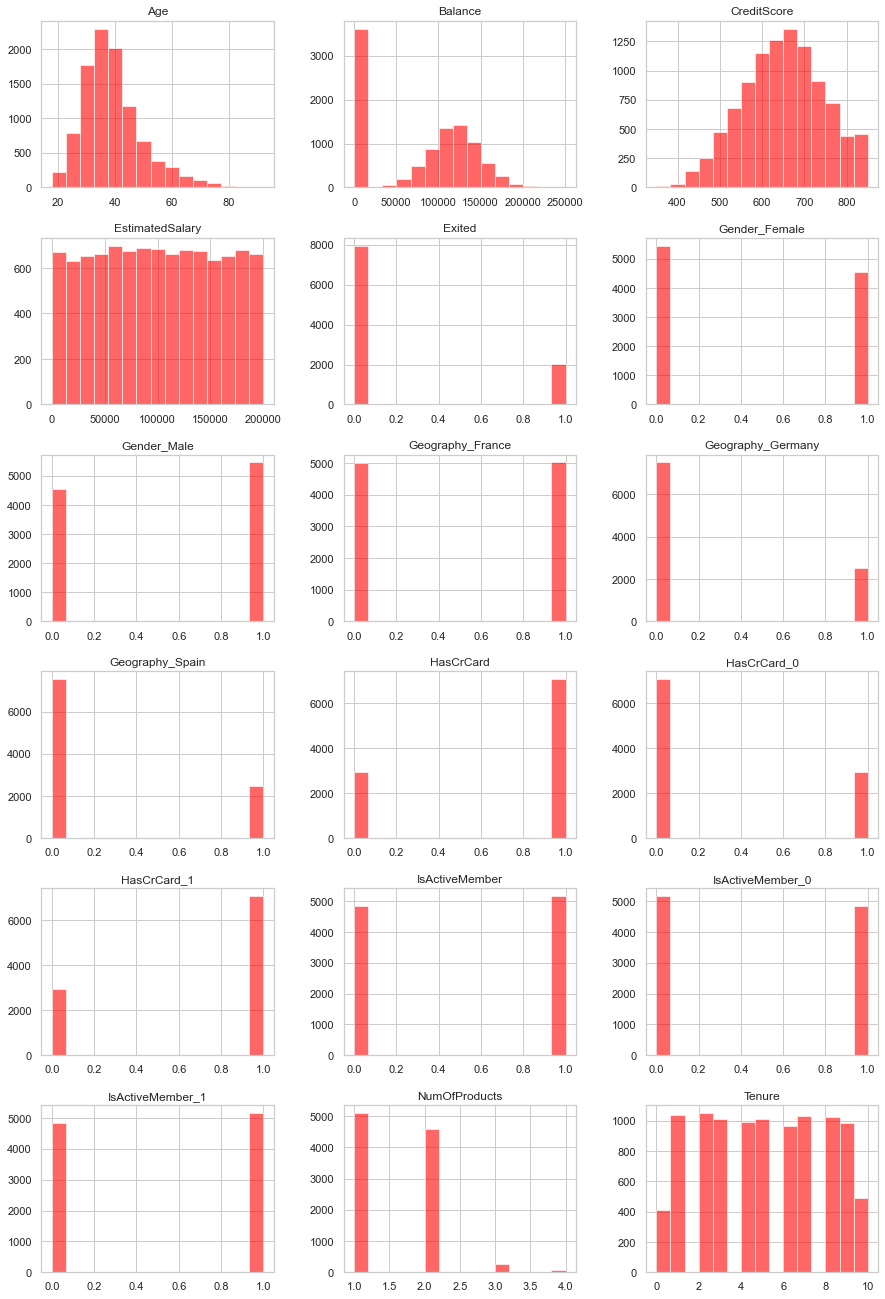

In [26]:
a = num_cols[num_cols.columns].hist(bins=15, figsize=(15,35), layout=(9,3),color = 'red',alpha=0.6)

In [27]:
cat_col = data.select_dtypes(exclude=np.number)

In [28]:
cat_col.columns

Index(['Geography', 'Gender'], dtype='object')

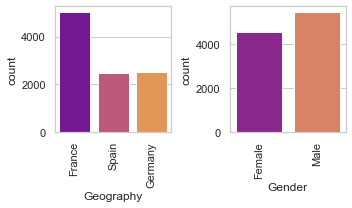

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
for variable, subplot in zip(cat_col, ax.flatten()):
    sns.countplot(data[variable], ax=subplot,palette = 'plasma')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.tight_layout()

In [30]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'HasCrCard_0', 'HasCrCard_1',
       'IsActiveMember_0', 'IsActiveMember_1'],
      dtype='object')

In [31]:
data.columns.shape

(20,)

In [32]:
cat_col.columns.shape

(2,)

In [33]:
num_cols.columns.shape

(18,)

In [34]:
cat_col_encoded = pd.get_dummies(cat_col)

In [35]:
cat_col_encoded.head()

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,0,0,1,0
1,0,0,1,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,0,0,1,1,0


In [36]:
df = pd.concat([num_cols,cat_col_encoded],sort=False,axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,...,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,...,0,0,1,0,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,...,0,1,0,0,1,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,...,0,0,1,1,0,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,...,0,1,0,1,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,...,0,0,1,0,1,0,0,1,1,0


In [37]:
X = df.drop(columns='Exited')
y = df['Exited']

In [38]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8000, 22) (8000,)
Test set: (2000, 22) (2000,)


In [39]:
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [41]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8155
Test set Accuracy:  0.764


In [42]:
metrics.confusion_matrix(y_train, neigh.predict(X_train))

array([[6153,  203],
       [1273,  371]], dtype=int64)

In [43]:
metrics.confusion_matrix(y_test, yhat)

array([[1491,  116],
       [ 356,   37]], dtype=int64)

In [44]:
Ks = 100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.6865, 0.782 , 0.739 , 0.7855, 0.764 , 0.792 , 0.777 , 0.796 ,
       0.786 , 0.798 , 0.791 , 0.7975, 0.795 , 0.7975, 0.7945, 0.799 ,
       0.7965, 0.8005, 0.8005, 0.8015, 0.8   , 0.8035, 0.801 , 0.8025,
       0.8015, 0.8025, 0.8025, 0.803 , 0.8035, 0.804 , 0.8035, 0.803 ,
       0.803 , 0.8035, 0.803 , 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035, 0.8035,
       0.8035, 0.8035, 0.8035])

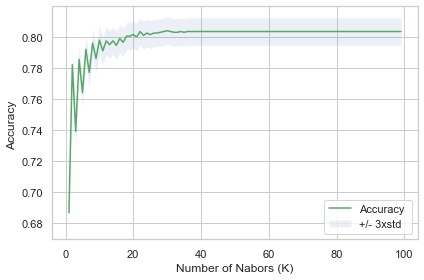

In [45]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [46]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.804 with k= 30


## LDA model

#### Data processing and EDA

In [47]:
data = pd.read_csv('Churn Modeling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [48]:
data.iloc[:,4:6].head()

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


In [49]:
list1=[]
for i in data.columns:
    a=data[i].isnull().sum()/ len(data)
    list1.append(a)
a=pd.Series(list1,index=list(data.columns))
a.sort_values(ascending=False)

Exited             0.0
EstimatedSalary    0.0
IsActiveMember     0.0
HasCrCard          0.0
NumOfProducts      0.0
Balance            0.0
Tenure             0.0
Age                0.0
Gender             0.0
Geography          0.0
CreditScore        0.0
Surname            0.0
CustomerId         0.0
RowNumber          0.0
dtype: float64

In [50]:
list2=[]
for i in data.columns:
    a=data[i].duplicated().sum()/ len(data)
    list2.append(a)
a=pd.Series(list2,index=list(data.columns))
a.sort_values

<bound method Series.sort_values of RowNumber          0.0000
CustomerId         0.0000
Surname            0.7068
CreditScore        0.9540
Geography          0.9997
Gender             0.9998
Age                0.9930
Tenure             0.9989
Balance            0.3618
NumOfProducts      0.9996
HasCrCard          0.9998
IsActiveMember     0.9998
EstimatedSalary    0.0001
Exited             0.9998
dtype: float64>

In [51]:
X = data.iloc[:, 3:13].values
y = data.iloc[:, 13].values

In [52]:
le_1 = LabelEncoder()
X[:,1] = le_1.fit_transform(X[:,1])
le_2 = LabelEncoder()
X[:,2] = le_2.fit_transform(X[:,2])

In [53]:
Xdf=pd.DataFrame(X,columns=data.columns[3:13])

In [54]:
Xdf.iloc[:,1:3].head()

,Geography,Gender
0,0,0
1,2,0
2,0,0
3,0,0
4,2,0


In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [56]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [58]:
lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [59]:
lda = LDA(n_components=2)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [60]:
lda.score(X=X_test,y=y_test)

0.813

In [61]:
c=lda.predict(X_test)

In [65]:
cm = confusion_matrix(y_test, c)
print(cm)
print('Accuracy' + ' '+str(accuracy_score(y_test, c)))

[[1549   58]
 [ 316   77]]
Accuracy 0.813


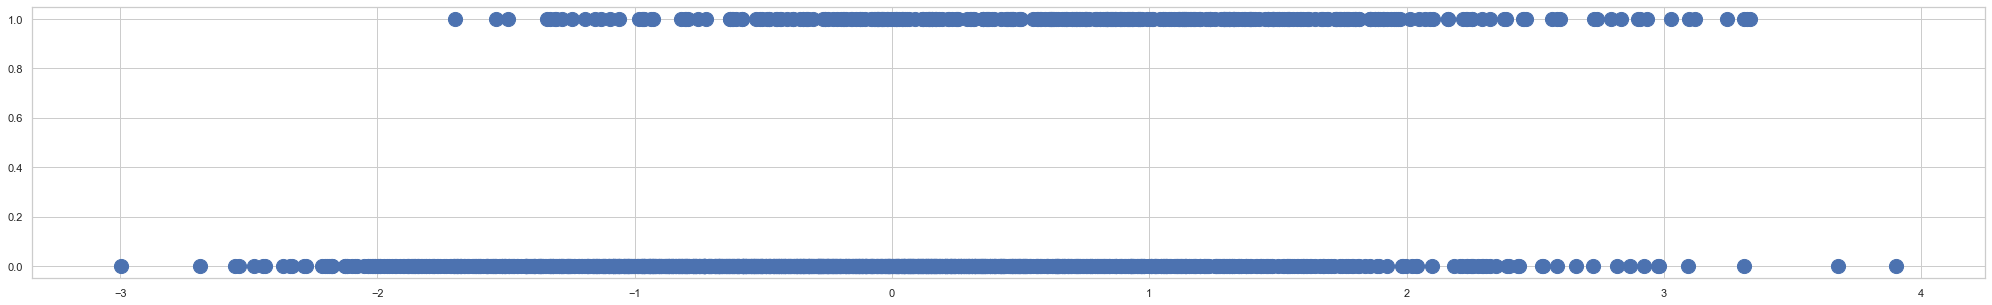

In [66]:
plt.figure(figsize = (35, 5))
plt.scatter(X_test,y_test, s=200)

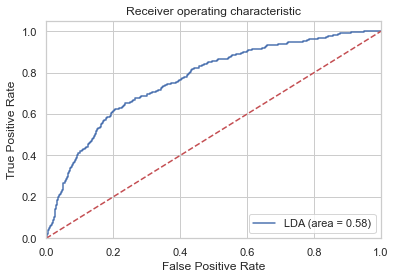

In [67]:
logit_roc_auc = roc_auc_score(y_test, lda.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lda.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LDA (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Quadratic Model Discriminant Analysis

#### Data processing and EDA

In [68]:
data = pd.read_csv(r'Churn Modeling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [69]:
data.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Change the Geography and Gender to dummy variable in order to do further analysis

In [70]:
data['Male'] = [1 if x =='Male' else 0 for x in data['Gender']] 
data['Geography_France'] = [1 if x =='France' else 0 for x in data['Geography']] 
data['Geography_Spain'] = [1 if x =='Spain' else 0 for x in data['Geography']] 
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geography_France,Geography_Spain
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,1,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,1,0
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,1,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


### Evaluate correlation between all the features
If the correlation between different features is high, we need to consider their interactions to create new features.\
Explore the correlation between each features and dependent variable 'Exited'. If the coefficient is small, the variable can be removed to avoid overfitting. However, in this model, we should choose all the features because of two reasons:\
1. All coefficients of correlation between each features and 'Exited' is high enough, the lowest  absolute value is 0.0072.
2. These dataset only have 10 features. We really do not need to worry about the overfitting problem.
From this correlation matrix, we could see that feature 'Age' shows a highest positive correlation with 'Exited', and 'IsActiveMember' has highest negative correlation.

In [71]:
# Make correlation between all varible used in basic QDA model as a new dataframe
Churn_Modeling = data.iloc[:,np.r_[3, 6:16]]
corr = Churn_Modeling.corr()
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geography_France
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.002857,-0.008928
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,-0.027544,-0.039208
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.014733,-0.002848
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.012087,-0.231329
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.021859,0.001230
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.005766,0.002467
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.022544,0.003317
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.008112,-0.003332
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.106512,-0.104955
Male,-0.002857,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512,1.000000,0.006772


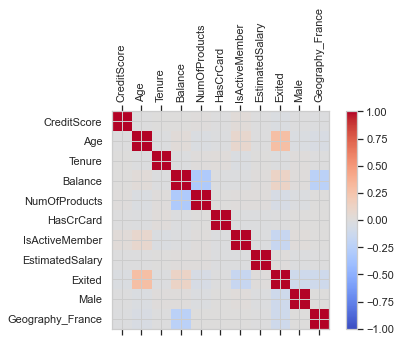

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(Churn_Modeling.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(Churn_Modeling.columns)
ax.set_yticklabels(Churn_Modeling.columns)
plt.show()

### Evaluate covariance between all the features
Covariance indicates the direction of the linear relationship between features.\
Actually the value of Covariance is meaningless, the most important thing is the sign of the value.\
Covariance between Exited and CreditScore is Negative, means that these two features tend to move in the inverse direction, if CreditScore tend to be high, the people will have a lower tendency to exit.

In [73]:
# For variance covariance matrix
covMatrix = Churn_Modeling.cov()
covMatrix

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geography_France
CreditScore,9341.860157,-4.019150,0.235355,3.780408e+04,0.687999,-0.240492,1.239139,-7.694701e+03,-1.054722,-0.137480,-0.431483
Age,-4.019150,109.994084,-0.303229,1.852533e+04,-0.187157,-0.056036,0.448026,-4.343373e+03,1.205250,-0.143841,-0.205611
Tenure,0.235355,-0.303229,8.364673,-2.211395e+03,0.022616,0.029773,-0.040997,1.294687e+03,-0.016309,0.021217,-0.004118
Balance,37804.076998,18525.333354,-2211.394696,3.893436e+09,-11039.815064,-422.619801,-314.483074,4.592389e+07,2978.931708,375.525656,-7217.498690
NumOfProducts,0.687999,-0.187157,0.022616,-1.103982e+04,0.338322,0.000844,0.002794,4.751478e+02,-0.011203,-0.006331,0.000358
HasCrCard,-0.240492,-0.056036,0.029773,-4.226198e+02,0.000844,0.207791,-0.002703,-2.604105e+02,-0.001310,0.001309,0.000562
IsActiveMember,1.239139,0.448026,-0.040997,-3.144831e+02,0.002794,-0.002703,0.249797,-3.282927e+02,-0.031429,0.005610,0.000829
EstimatedSalary,-7694.701048,-4343.372926,1294.686597,4.592389e+07,475.147781,-260.410522,-328.292660,3.307457e+09,280.204670,-232.307503,-95.806597
Exited,-1.054722,1.205250,-0.016309,2.978932e+03,-0.011203,-0.001310,-0.031429,2.802047e+02,0.162223,-0.021361,-0.021137
Male,-0.137480,-0.143841,0.021217,3.755257e+02,-0.006331,0.001309,0.005610,-2.323075e+02,-0.021361,0.247936,0.001686


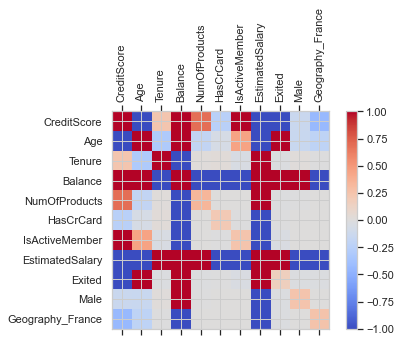

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(covMatrix,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(Churn_Modeling.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(Churn_Modeling.columns)
ax.set_yticklabels(Churn_Modeling.columns)
plt.show()

### Evaluate covariance between all the features just for 'Exited' is 1

In [75]:
Churn_Modeling_1 = Churn_Modeling[Churn_Modeling['Exited']==1]
cov_1 = Churn_Modeling_1.cov()
cov_1

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geography_France
CreditScore,10064.403894,-10.804522,8.167070,1.017950e+05,0.034750,-0.567059,-0.037500,-3.202934e+05,0.0,-0.856898,-1.367246
Age,-10.804522,95.288084,-0.615518,-1.283347e+04,-0.044784,-0.133746,-0.026978,-6.122171e+02,0.0,0.029705,0.117496
Tenure,8.167070,-0.615518,8.620720,5.021507e+03,0.051623,0.001362,-0.051850,7.810327e+03,0.0,-0.000297,0.026757
Balance,101795.034182,-12833.470446,5021.507043,3.405982e+09,-1050.060495,-247.183476,76.567484,-4.238441e+07,0.0,1159.083534,-7923.257526
NumOfProducts,0.034750,-0.044784,0.051623,-1.050060e+03,0.642435,-0.002798,0.021474,1.339780e+03,0.0,-0.020009,0.000531
HasCrCard,-0.567059,-0.133746,0.001362,-2.471835e+02,-0.002798,0.210476,-0.015626,-6.402028e+02,0.0,0.000608,0.001353
IsActiveMember,-0.037500,-0.026978,-0.051850,7.656748e+01,0.021474,-0.015626,0.230744,-2.930091e+02,0.0,-0.001484,0.002815
EstimatedSalary,-320293.368017,-612.217095,7810.327162,-4.238441e+07,1339.780079,-640.202752,-293.009109,3.353848e+09,0.0,-829.807688,785.175157
Exited,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000
Male,-0.856898,0.029705,-0.000297,1.159084e+03,-0.020009,0.000608,-0.001484,-8.298077e+02,0.0,0.246622,-0.003479


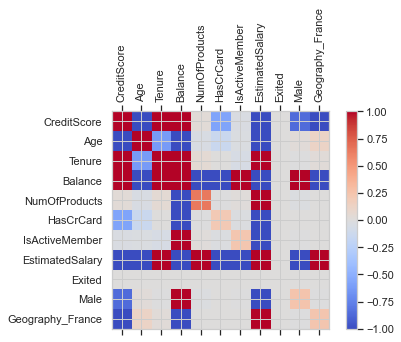

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov_1,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(Churn_Modeling_1.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(Churn_Modeling_1.columns)
ax.set_yticklabels(Churn_Modeling_1.columns)
plt.show()

### Evaluate covariance between all the features just for 'Exited' is 0

In [77]:
Churn_Modeling_0 = Churn_Modeling[Churn_Modeling['Exited']==0]
cov_0 = Churn_Modeling_0.cov()
cov_0 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geography_France
CreditScore,9149.656542,7.556444,-1.926036,4.576866e+04,0.763658,-0.167715,1.309129,7.452829e+04,0.0,-0.127948,-0.364837
Age,7.556444,102.522974,-0.071241,-1.248062e+03,-0.119060,-0.023943,0.862793,-7.912452e+03,0.0,0.011072,-0.091041
Tenure,-1.926036,-0.071241,8.298189,-3.685125e+03,0.013787,0.036876,-0.042195,-3.359181e+02,0.0,0.024024,-0.014683
Balance,45768.660297,-1248.062021,-3685.124822,3.949876e+09,-13337.375656,-437.313123,310.273937,6.204950e+07,0.0,667.823218,-6550.478863
NumOfProducts,0.763658,-0.119060,0.013787,-1.333738e+04,0.259626,0.001662,-0.004708,2.784095e+02,0.0,-0.004687,-0.001520
HasCrCard,-0.167715,-0.023943,0.036876,-4.373131e+02,0.001662,0.207117,0.000282,-1.604821e+02,0.0,0.001271,0.000146
IsActiveMember,1.309129,0.862793,-0.042195,3.102739e+02,-0.004708,0.000282,0.247054,-2.691808e+02,0.0,0.002228,-0.004822
EstimatedSalary,74528.287258,-7912.451563,-335.918125,6.204950e+07,278.409505,-160.482105,-269.180757,3.295401e+09,0.0,-33.210468,-275.247655
Exited,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000
Male,-0.127948,0.011072,0.024024,6.678232e+02,-0.004687,0.001271,0.002228,-3.321047e+01,0.0,0.244771,-0.000488


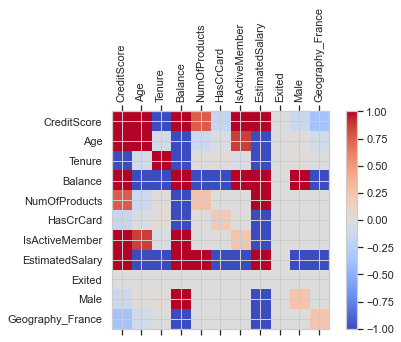

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cov_0,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(Churn_Modeling_0.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(Churn_Modeling_0.columns)
ax.set_yticklabels(Churn_Modeling_0.columns)
plt.show()

#### Build up Quadratic Discriminant Analysis model

In [79]:
X_qda = pd.concat([data.iloc[:,3],data.iloc[:,6:12,],data.iloc[:,14:15]], axis=1)
y_qda = data.iloc[:,13]

In [80]:
X_train_qda, X_test_qda, y_train_qda, y_test_qda = train_test_split(X_qda, y_qda, test_size=0.2, random_state=42)

In [81]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(X_train_qda, y_train_qda)
y_pred_qda=qda_model.predict(X_test_qda)

###### From Quadratic Discriminant Analysis model, we get the accuracy is 0.8335.

In [82]:
print('accuracy_score')
print(accuracy_score(y_test_qda, y_pred_qda))

accuracy_score
0.8335


In [83]:
print('Confusion Matrix:')
print(confusion_matrix(y_test_qda,y_pred_qda))

Confusion Matrix:
[[1562   45]
 [ 288  105]]


In [84]:
print('Confusion Matrix:')
print(confusion_matrix(y_test_qda,y_pred_qda))

Confusion Matrix:
[[1562   45]
 [ 288  105]]


In [85]:
print('Classification Report')
print(classification_report(y_test_qda,y_pred_qda))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1607
           1       0.70      0.27      0.39       393

    accuracy                           0.83      2000
   macro avg       0.77      0.62      0.65      2000
weighted avg       0.82      0.83      0.80      2000



In [86]:
qda_roc_auc = roc_auc_score(y_test_qda, y_pred_qda)
print('Accuracy of QDA on test data is %.3f' %(qda_roc_auc))

Accuracy of QDA on test data is 0.620


In [87]:
fpr, tpr, thresholds=roc_curve(y_test_qda,y_pred_qda)
roc_curve_qda =auc(fpr,tpr)
print('ROC curve of QDA on test data is %.3f' %(roc_curve_qda))

ROC curve of QDA on test data is 0.620


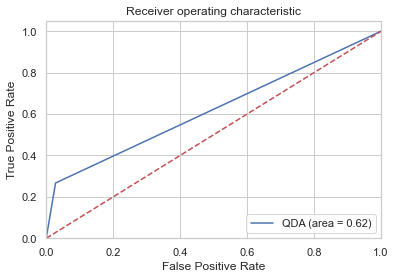

In [88]:
plt.figure()
plt.plot(fpr, tpr, label='QDA (area = %0.2f)' % qda_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### A glance at how the QDA Classification works on the Test Dataset:

In [89]:
def plotModel(model, x, y, label):
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    import  matplotlib.pyplot as pl
    from matplotlib import colors
    colDict = {'red': [(0, 1, 1), (1, 0.7, 0.7)],
               'green': [(0, 1, 0.5), (1, 0.7, 0.7)],
               'blue': [(0, 1, 0.5), (1, 1, 1)]}
    cmap = colors.LinearSegmentedColormap('red_blue_classes', colDict)
    plt.cm.register_cmap(cmap=cmap)
    nx, ny = 200, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes')
    plt.contour(xx, yy, Z, [0.5], linewidths=1., colors='k')
    plt.contour(xx, yy, Z, [1], linewidths=1., colors='k')
    plt.scatter(x, y, c = label)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
labels = X_train_qda.columns.values

In [90]:
def pairPlot(model, i, j):
    model.fit(X_test_qda.iloc[:,[i,j]], y_test_qda)
    plotModel(model, X_test_qda.iloc[:, i], X_test_qda.iloc[:, j], y_test_qda)
    plt.xlabel(labels[i])
    plt.ylabel(labels[j])

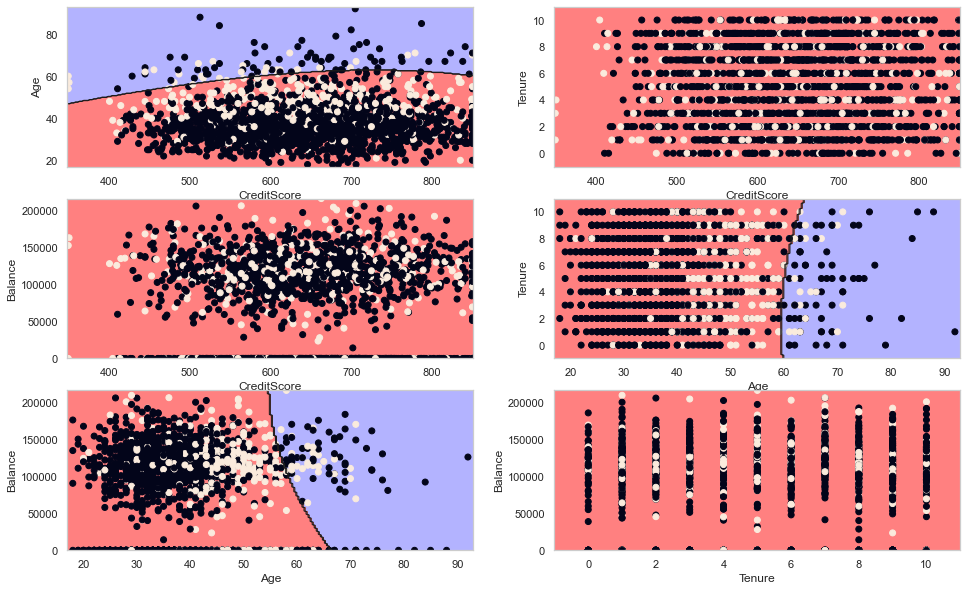

In [91]:

plt.rcParams['figure.figsize'] = 16, 10
plt.subplot(321)
pairPlot(qda_model, 0, 1)

plt.subplot(322)
pairPlot(qda_model, 0, 2)

plt.subplot(323)
pairPlot(qda_model, 0, 3)

plt.subplot(324)
pairPlot(qda_model, 1, 2)

plt.subplot(325)
pairPlot(qda_model, 1, 3)

plt.subplot(326)
pairPlot(qda_model, 2, 3)


## Random Forest Model

In [92]:
data = pd.read_csv('Churn Modeling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Data processing and EDA

In [93]:
data.drop('RowNumber', axis=1, inplace=True)

In [94]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [95]:
data = pd.get_dummies(data, columns=['Geography', 'Gender'])
data = data[[col for col in data.columns if col != 'Exited'] + ['Exited']]
data.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0,1
1,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0,0
2,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0,1
3,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0,0
4,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0,0


In [96]:
labels = np.array(data['Exited'])
features = np.array(data.loc[:,'CreditScore':'Gender_Male'])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [98]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


### Baseline Model

In [99]:
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [100]:
baseline_pred = np.array([0]*len(y_test))
baseline_acc = sum(y_test == baseline_pred) / len(y_test)
print(baseline_acc)

0.8035


### Random Forest

In [101]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [102]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [103]:
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)

print('accuracy: ', rf_acc)

accuracy:  0.864


In [104]:
feature_names = data.columns[2:-1]

importances = rf.feature_importances_

feature_importances = [(feature+':',imp) for feature, imp in zip(feature_names, importances)]
print(sorted(feature_importances, key=lambda x: x[1], reverse=True))

[('Age:', 0.2390797648406282), ('EstimatedSalary:', 0.14587525843482005), ('CreditScore:', 0.14332780935137837), ('Balance:', 0.1404102196335975), ('NumOfProducts:', 0.1303849675079369), ('Tenure:', 0.08449999052897869), ('IsActiveMember:', 0.039449591286891225), ('Geography_Germany:', 0.020308080863820157), ('HasCrCard:', 0.018607181345318597), ('Geography_France:', 0.010479944153728226), ('Gender_Male:', 0.009384893825065414), ('Gender_Female:', 0.009113660732630638), ('Geography_Spain:', 0.009078637495205955)]


<BarContainer object of 13 artists>

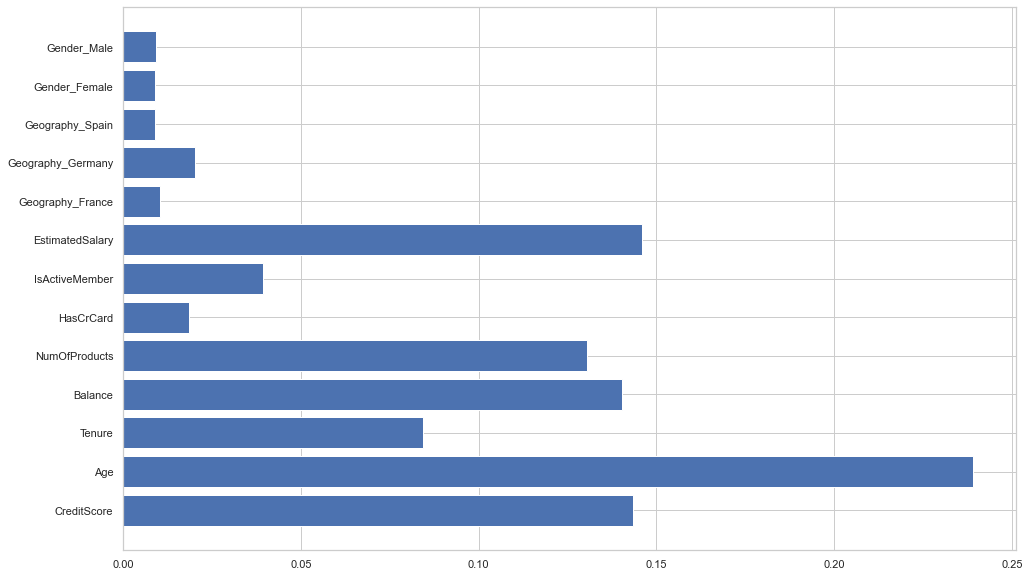

In [105]:
plt.barh(feature_names, importances)

###  Sequential model

#### Data processing and EDA

In [106]:
df=pd.read_csv('Churn Modeling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [107]:
X=df.iloc[:,3:13]
y=df.iloc[:,13]

##### check our dataset

In [108]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [109]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

##### convert categorical variables to binary variables

In [110]:
country=pd.get_dummies(X['Geography'],drop_first=True)
gender=pd.get_dummies(X["Gender"],drop_first=True)

In [111]:
X=pd.concat([X,country,gender],axis=1)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1,0


In [112]:
X=X.drop(['Geography','Gender'],axis=1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


##### Split dataset

In [113]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

##### sacle data values 

In [114]:
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

#### Create Sequential model

In [115]:
model=Sequential()
model.add(Dense(activation='relu',input_dim=11,units=8,kernel_initializer='RandomNormal'))
model.add(Dense(activation='relu',units=8,kernel_initializer='uniform'))
model.add(Dense(activation='relu',units=8,kernel_initializer='uniform'))
model.add(Dense(activation='relu',units=6,kernel_initializer='uniform'))
model.add(Dense(activation='sigmoid',units=1,kernel_initializer='uniform'))
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=10,epochs=10)
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)
acc=accuracy_score(y_test,y_pred)
acc

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8000/8000 [==============================] - 1s 101us/step - loss: 0.1579 - accuracy: 0.7944
Epoch 2/10
8000/80

0.839

In [116]:
model=Sequential()
model.add(Dense(activation='relu',input_dim=11,units=6,kernel_initializer='uniform'))
model.add(Dense(activation='relu',units=6,kernel_initializer='uniform'))
model.add(Dense(activation='sigmoid',units=1,kernel_initializer='uniform'))
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=10,epochs=10)
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)
acc=accuracy_score(y_test,y_pred)
acc

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8000/8000 [==============================] - 1s 88us/step - loss: 0.4875 - accuracy: 0.7941
Epoch 2/10
8000/8000 [==============================] - 1s 75us/step - loss: 0.4305 - accuracy: 0.7945
Epoch 3/10
8000/8000 [==============================] - 1s 76us/step - loss: 0.4239 - accuracy: 0.7989
Epoch 4/10
8000/8000 [==============================] - 1s 76us/step - loss: 

0.8335

In [117]:
model=Sequential()
model.add(Dense(activation='relu',input_dim=11,units=6,kernel_initializer='uniform'))
model.add(Dense(activation='relu',units=6,kernel_initializer='uniform'))
model.add(Dense(activation='relu',units=6,kernel_initializer='uniform'))
model.add(Dense(activation='sigmoid',units=1,kernel_initializer='uniform'))
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=10,epochs=20)
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)
acc=accuracy_score(y_test,y_pred)
acc

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
8000/8000 [==============================] - 1s 88us/step - loss: 0.1584 - accuracy: 0.7936
Epoch 2/20
8000/8000 [==============================] - 1s 84us/step - loss: 0.1338 - accuracy: 0.7990
Epoch 3/20
8000/8000 [==========================

0.8385